In [1]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")

# Adjust this to your tracking URI if needed
mlflow.set_tracking_uri("file:///Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Moons/mlruns")

# If you already have `all_runs` in the notebook, you can skip this cell.
all_runs = mlflow.search_runs(search_all_experiments=True)
print(f"Found {len(all_runs)} runs")
print(all_runs.columns)

Found 2128 runs
Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.accuracy', 'metrics.precision',
       'metrics.train_loss', 'metrics.recall', 'metrics.f1_score',
       'metrics.val_f1', 'metrics.val_loss', 'params.test_size',
       'params.num_samples', 'params.config_version', 'params.loss_function',
       'params.dataset', 'params.batch_size', 'params.gamma',
       'params.num_layer', 'params.learning_rate', 'params.alpha',
       'params.val_size', 'params.imbalance_ratio', 'params.noise',
       'params.epochs', 'params.hidden_size', 'params.ce_weight',
       'tags.mlflow.user', 'tags.mlflow.runName', 'tags.mlflow.source.name',
       'tags.mlflow.source.git.commit', 'tags.mlflow.source.type'],
      dtype='object')


In [3]:
print(all_runs.describe())
print(all_runs.columns)

       metrics.accuracy  metrics.precision  metrics.train_loss  \
count       2128.000000        2128.000000        1.994000e+03   
mean           0.855037           0.603678        1.952724e-01   
std            0.164545           0.351266        4.762910e-01   
min            0.165000           0.000000        1.646445e-08   
25%            0.763000           0.312814        3.769076e-03   
50%            0.906000           0.684884        2.483073e-02   
75%            0.990000           0.941299        9.787214e-02   
max            1.000000           1.000000        2.881382e+00   

       metrics.recall  metrics.f1_score  metrics.val_f1  metrics.val_loss  
count     2128.000000       2128.000000     2128.000000      1.994000e+03  
mean         0.653680          0.564816        0.524127      2.156073e-01  
std          0.369893          0.334376        0.355328      5.605691e-01  
min          0.000000          0.000000        0.000000      2.488645e-09  
25%          0.331500    

In [4]:
# Get unique noise and imbalance_ratio values
noises = all_runs['params.noise'].unique()
imbalance_ratios = all_runs['params.imbalance_ratio'].unique()

# Create results list
all_results = []

# Iterate through all combinations
for noise in noises:
    for imbalance_ratio in imbalance_ratios:
        filtered_runs = all_runs[
            (all_runs['params.noise'] == noise) &
            (all_runs['params.imbalance_ratio'] == imbalance_ratio)
        ]

        if len(filtered_runs) == 0:
            continue

        # Group by loss function and number of layers, find best F1 score for each
        best_models = filtered_runs.groupby(['params.loss_function', 'params.num_layer']).apply(
            lambda group: group.loc[group['metrics.f1_score'].idxmax()]
        ).reset_index(drop=True)

        # Extract relevant information
        for idx, row in best_models.iterrows():
            loss_fn = row['params.loss_function']

            result = {
                'noise': noise,
                'imbalance_ratio': imbalance_ratio,
                'loss_fn': loss_fn,
                'n_layers': row['params.num_layer'],
                'f1_score': row['metrics.f1_score'],
                'run_id': row['run_id']
            }

            # Extract loss-specific parameters
            if loss_fn == 'focal':
                result['alpha'] = row['params.alpha']
                result['gamma'] = row['params.gamma']
            elif loss_fn == 'wce':
                result['weight'] = row['params.ce_weight']

            # Add all metrics columns
            metrics_cols = [col for col in row.index if col.startswith('metrics.')]
            for metric_col in metrics_cols:
                metric_name = metric_col.replace('metrics.', '')
                result[metric_name] = row[metric_col]

            all_results.append(result)

results_df = pd.DataFrame(all_results)


/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_68681/624213436.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby(['params.loss_function', 'params.num_layer']).apply(
/var/folders/pq/7tww9h2961b0pzlfhhzbszfw0000gn/T/ipykernel_68681/624213436.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby(['params.loss_function', 'params.num_la

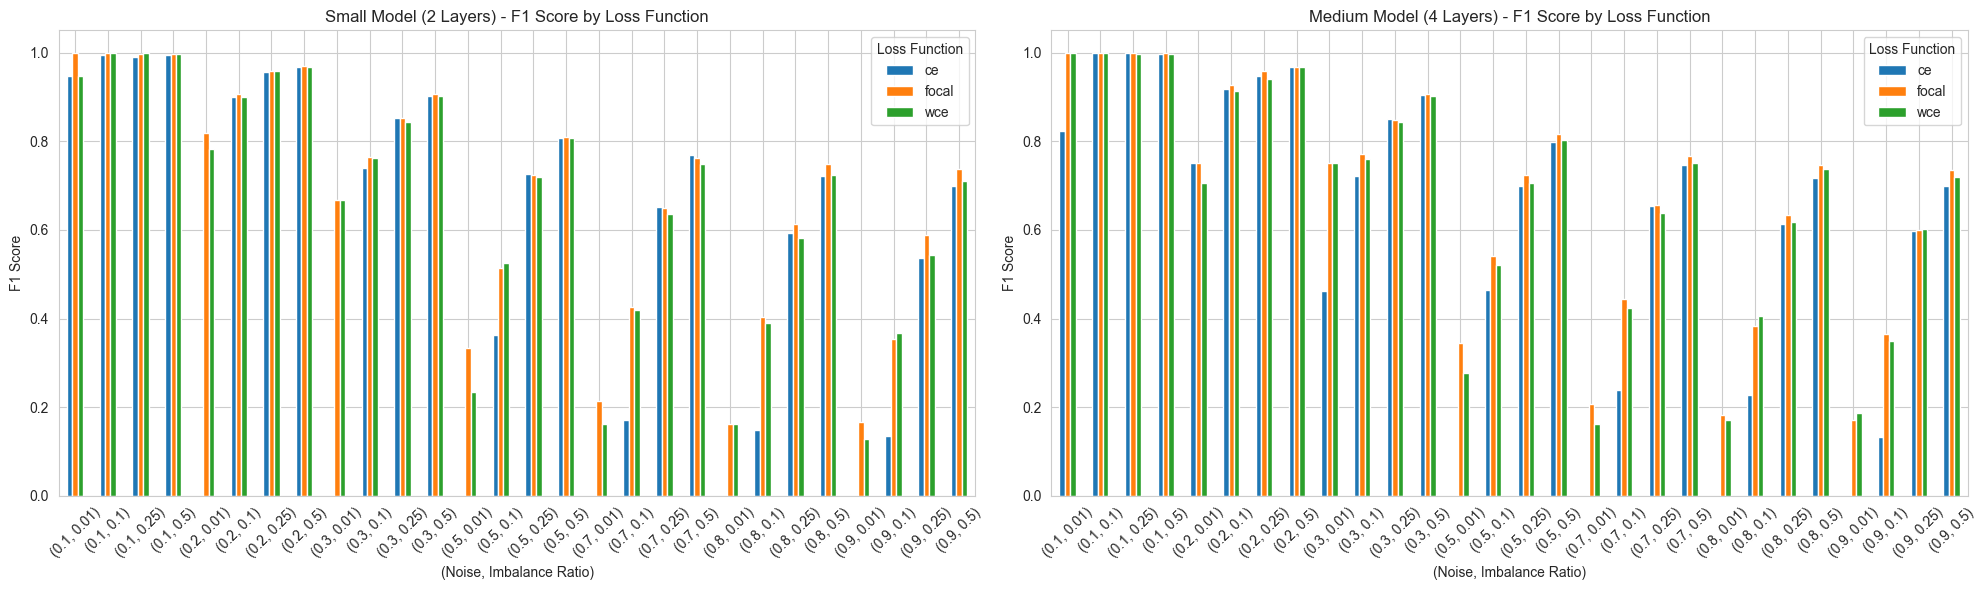

In [5]:
sns.set_style("whitegrid")

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Filter data for small model (2 layers)
small_model_df = results_df[results_df['n_layers'] == "2"]
pivot_f1_small = small_model_df.pivot_table(
    values='f1_score',
    index=['noise', 'imbalance_ratio'],
    columns='loss_fn',
    aggfunc='first'
)

# Filter data for medium model (4 layers)
medium_model_df = results_df[results_df['n_layers'] == "4"]
pivot_f1_medium = medium_model_df.pivot_table(
    values='f1_score',
    index=['noise', 'imbalance_ratio'],
    columns='loss_fn',
    aggfunc='first'
)

# Plot small model
pivot_f1_small.plot(kind='bar', ax=axes[0])
axes[0].set_title('Small Model (2 Layers) - F1 Score by Loss Function')
axes[0].set_xlabel('(Noise, Imbalance Ratio)')
axes[0].set_ylabel('F1 Score')
axes[0].legend(title='Loss Function')
axes[0].tick_params(axis='x', rotation=45)

# Plot medium model
pivot_f1_medium.plot(kind='bar', ax=axes[1])
axes[1].set_title('Medium Model (4 Layers) - F1 Score by Loss Function')
axes[1].set_xlabel('(Noise, Imbalance Ratio)')
axes[1].set_ylabel('F1 Score')
axes[1].legend(title='Loss Function')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("/Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Visulaisation/plots/BarPlot.png")
plt.show()


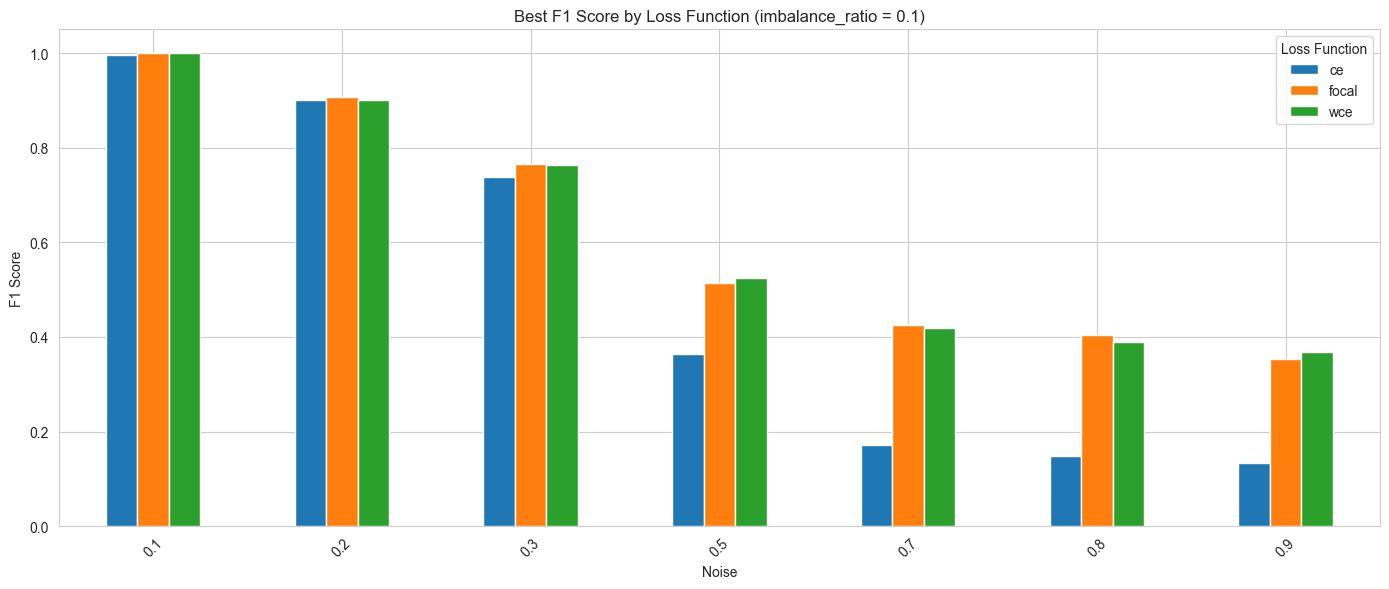

In [6]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Filter only imbalance_ratio == 0.01
filtered_df = results_df[results_df['imbalance_ratio'] == "0.1"]

# 1. F1 Score comparison across loss functions for each noise level (imbalance = 0.01)
fig, ax = plt.subplots(figsize=(14, 6))
pivot_f1 = filtered_df.pivot_table(
    values='f1_score',
    index='noise',          # only noise now, since imbalance is fixed
    columns='loss_fn',
    aggfunc='first'
)
pivot_f1.plot(kind='bar', ax=ax)
ax.set_title('Best F1 Score by Loss Function (imbalance_ratio = 0.1)')
ax.set_xlabel('Noise')
ax.set_ylabel('F1 Score')
ax.legend(title='Loss Function')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig(f"/Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Visulaisation/plots/BarPlot_imbalance_{0.1}.png")
plt.show()


In [7]:
def get_best_runs_per_config(all_runs: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    df = all_runs.copy()

    df = df[df['params.num_layer'].astype(int) == num_layer]

    df['noise'] = df['params.noise'].astype(float)
    df['imbalance_ratio'] = df['params.imbalance_ratio'].astype(float)
    df['loss_function'] = df['params.loss_function']

    group_cols = ['noise', 'imbalance_ratio', 'loss_function']

    best_idx = df.groupby(group_cols)['metrics.val_f1'].idxmax()
    best = df.loc[best_idx].reset_index(drop=True)

    return best

best_small = get_best_runs_per_config(all_runs, num_layer=2)
best_big   = get_best_runs_per_config(all_runs, num_layer=4)

display(best_small[['run_id', 'noise', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])
display(best_big[['run_id', 'noise', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])


,run_id,noise,imbalance_ratio,loss_function,metrics.val_f1
0,377f31ece5c14308b674dffdb46ee457,0.1,0.01,ce,1.000000
1,9c62010cb7c64ccf91784606a8ddcdf4,0.1,0.01,focal,1.000000
2,8977856a59de4b61aeb8af526eeeb974,0.1,0.01,wce,1.000000
3,15f610c835de4796afcf5c0e3bde5716,0.1,0.10,ce,1.000000
4,118599eaaf5e4b12b4f2b4ecded1433e,0.1,0.10,focal,1.000000
...,...,...,...,...,...
79,ce409311a28f417a930c7dba041d6120,0.9,0.25,focal,0.597561
80,ae7868adb131447096d72a9c68a09af7,0.9,0.25,wce,0.531100
81,1199535982d844f398fbf66f91cfb32d,0.9,0.50,ce,0.760956
82,6c8f216a480b4b59bf4f8eb23fb3f097,0.9,0.50,focal,0.756972


,run_id,noise,imbalance_ratio,loss_function,metrics.val_f1
0,7c2461a479ea45f98fb6ba2b0dbf09ba,0.1,0.01,ce,1.000000
1,9856964d72a94bc29833312af58cf0ff,0.1,0.01,focal,1.000000
2,4174c4f843ec4c368aa075495f7817b2,0.1,0.01,wce,1.000000
3,04d2e09127db4382bb9fc3b8df349af6,0.1,0.10,ce,1.000000
4,d47e2d78d8af4aa0b8b629222f3d5723,0.1,0.10,focal,1.000000
...,...,...,...,...,...
79,d2defa4dd07a4cd08d565e9f090cd215,0.9,0.25,focal,0.593660
80,032c7244d81a496aadf1a0732a76a943,0.9,0.25,wce,0.558974
81,5c5330d7fa0c440fae77d2fd3d21f232,0.9,0.50,ce,0.761523
82,e4b3c7c51ddb47f5a84598faa816898b,0.9,0.50,focal,0.771084


In [8]:
client = MlflowClient()

def fetch_val_f1_history(best_df: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    rows = []

    for _, row in best_df.iterrows():
        run_id = row['run_id']
        hist = client.get_metric_history(run_id, "val_f1")

        for m in hist:
            rows.append({
                "step": m.step,
                "val_f1": m.value,
                "noise": float(row['noise']),
                "imbalance_ratio": float(row['imbalance_ratio']),
                "loss_function": row['loss_function'],
                "num_layer": num_layer,
            })

    return pd.DataFrame(rows)

hist_small = fetch_val_f1_history(best_small, 2)
hist_big   = fetch_val_f1_history(best_big, 4)


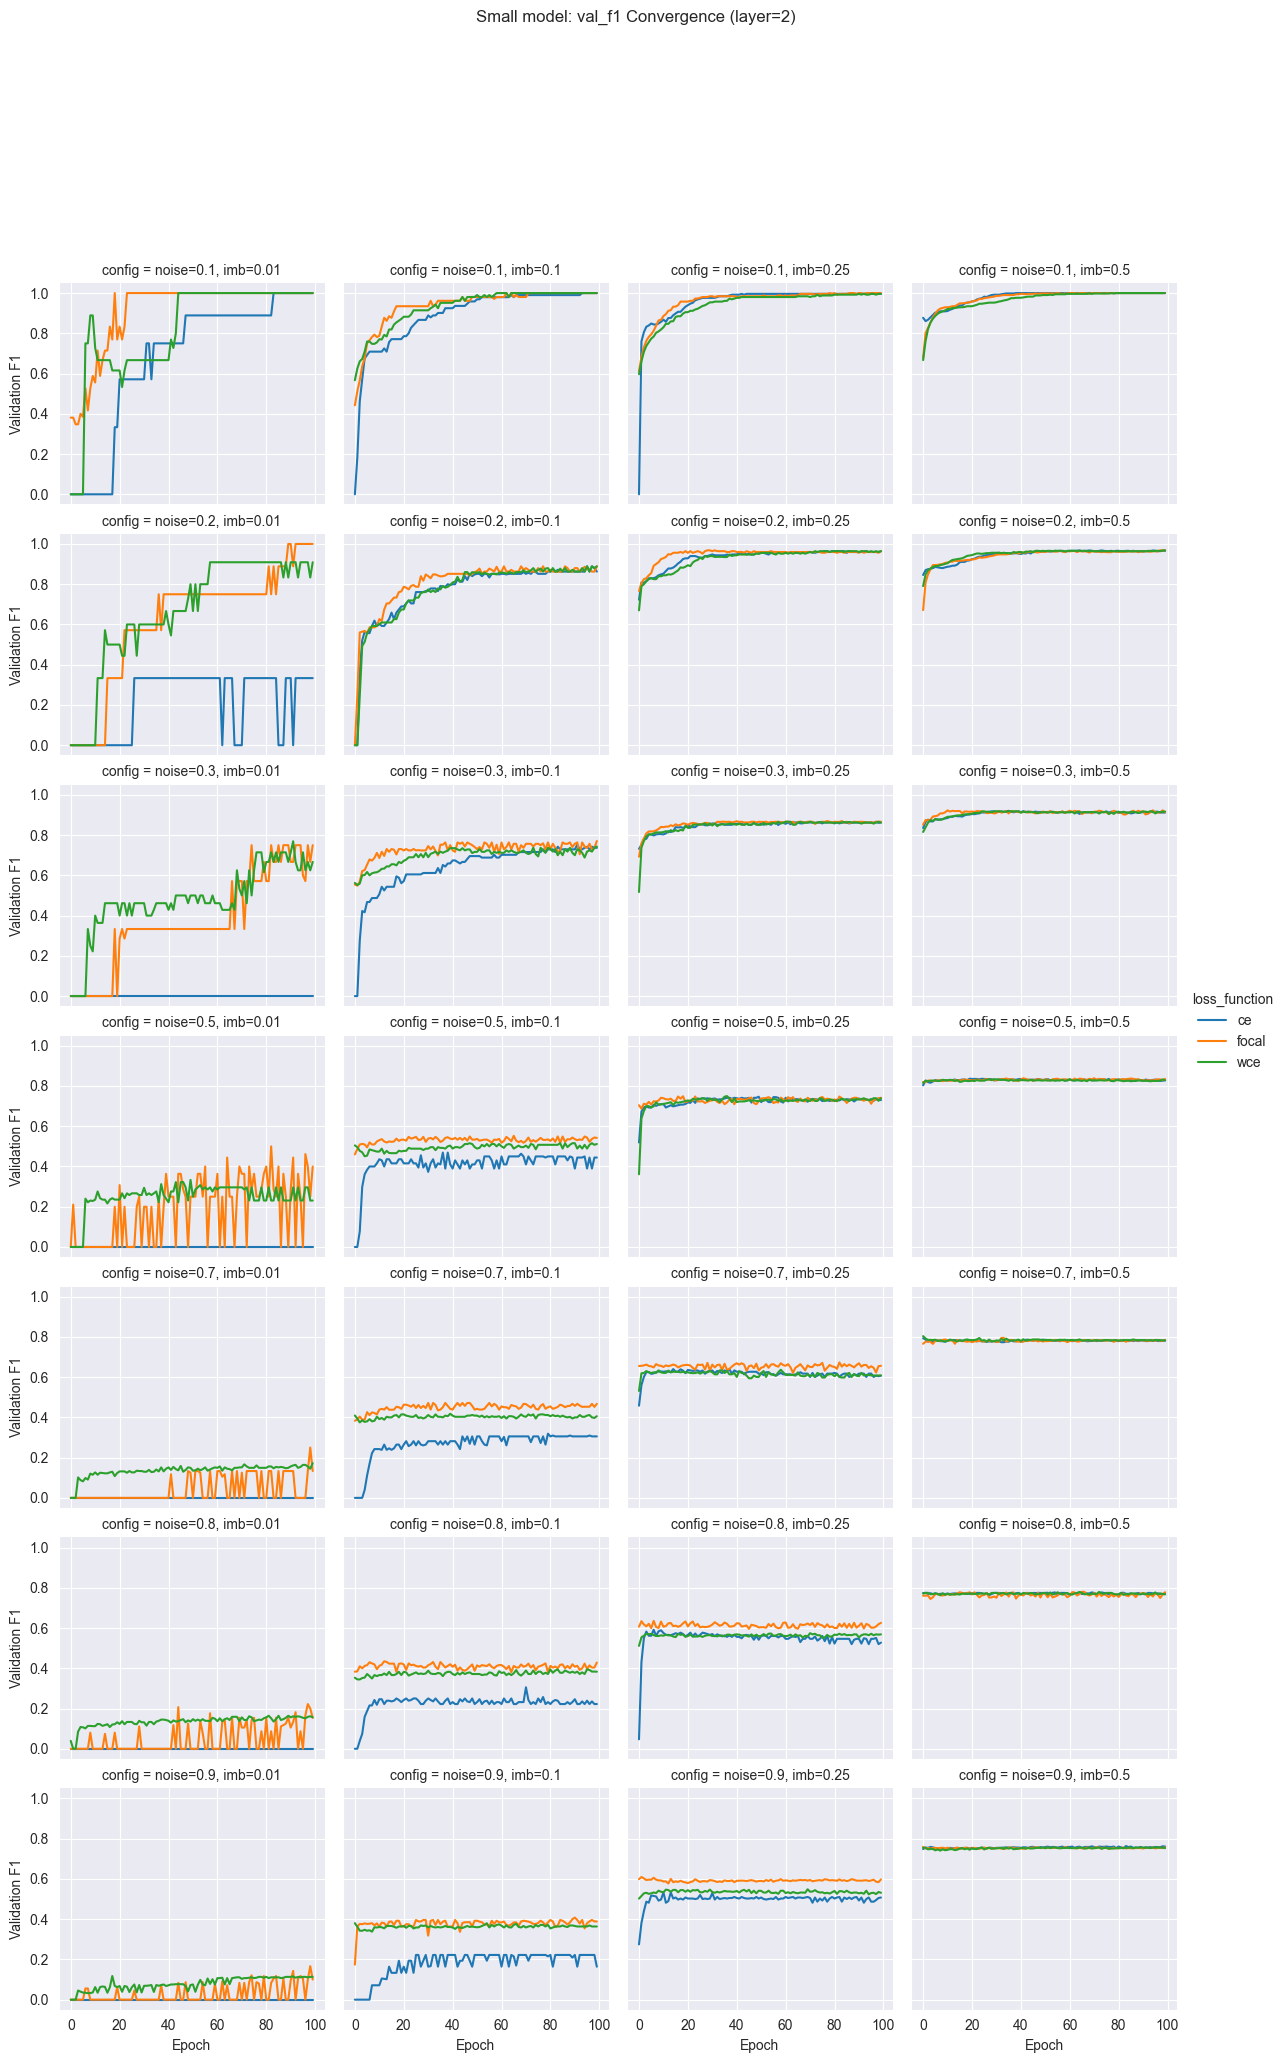

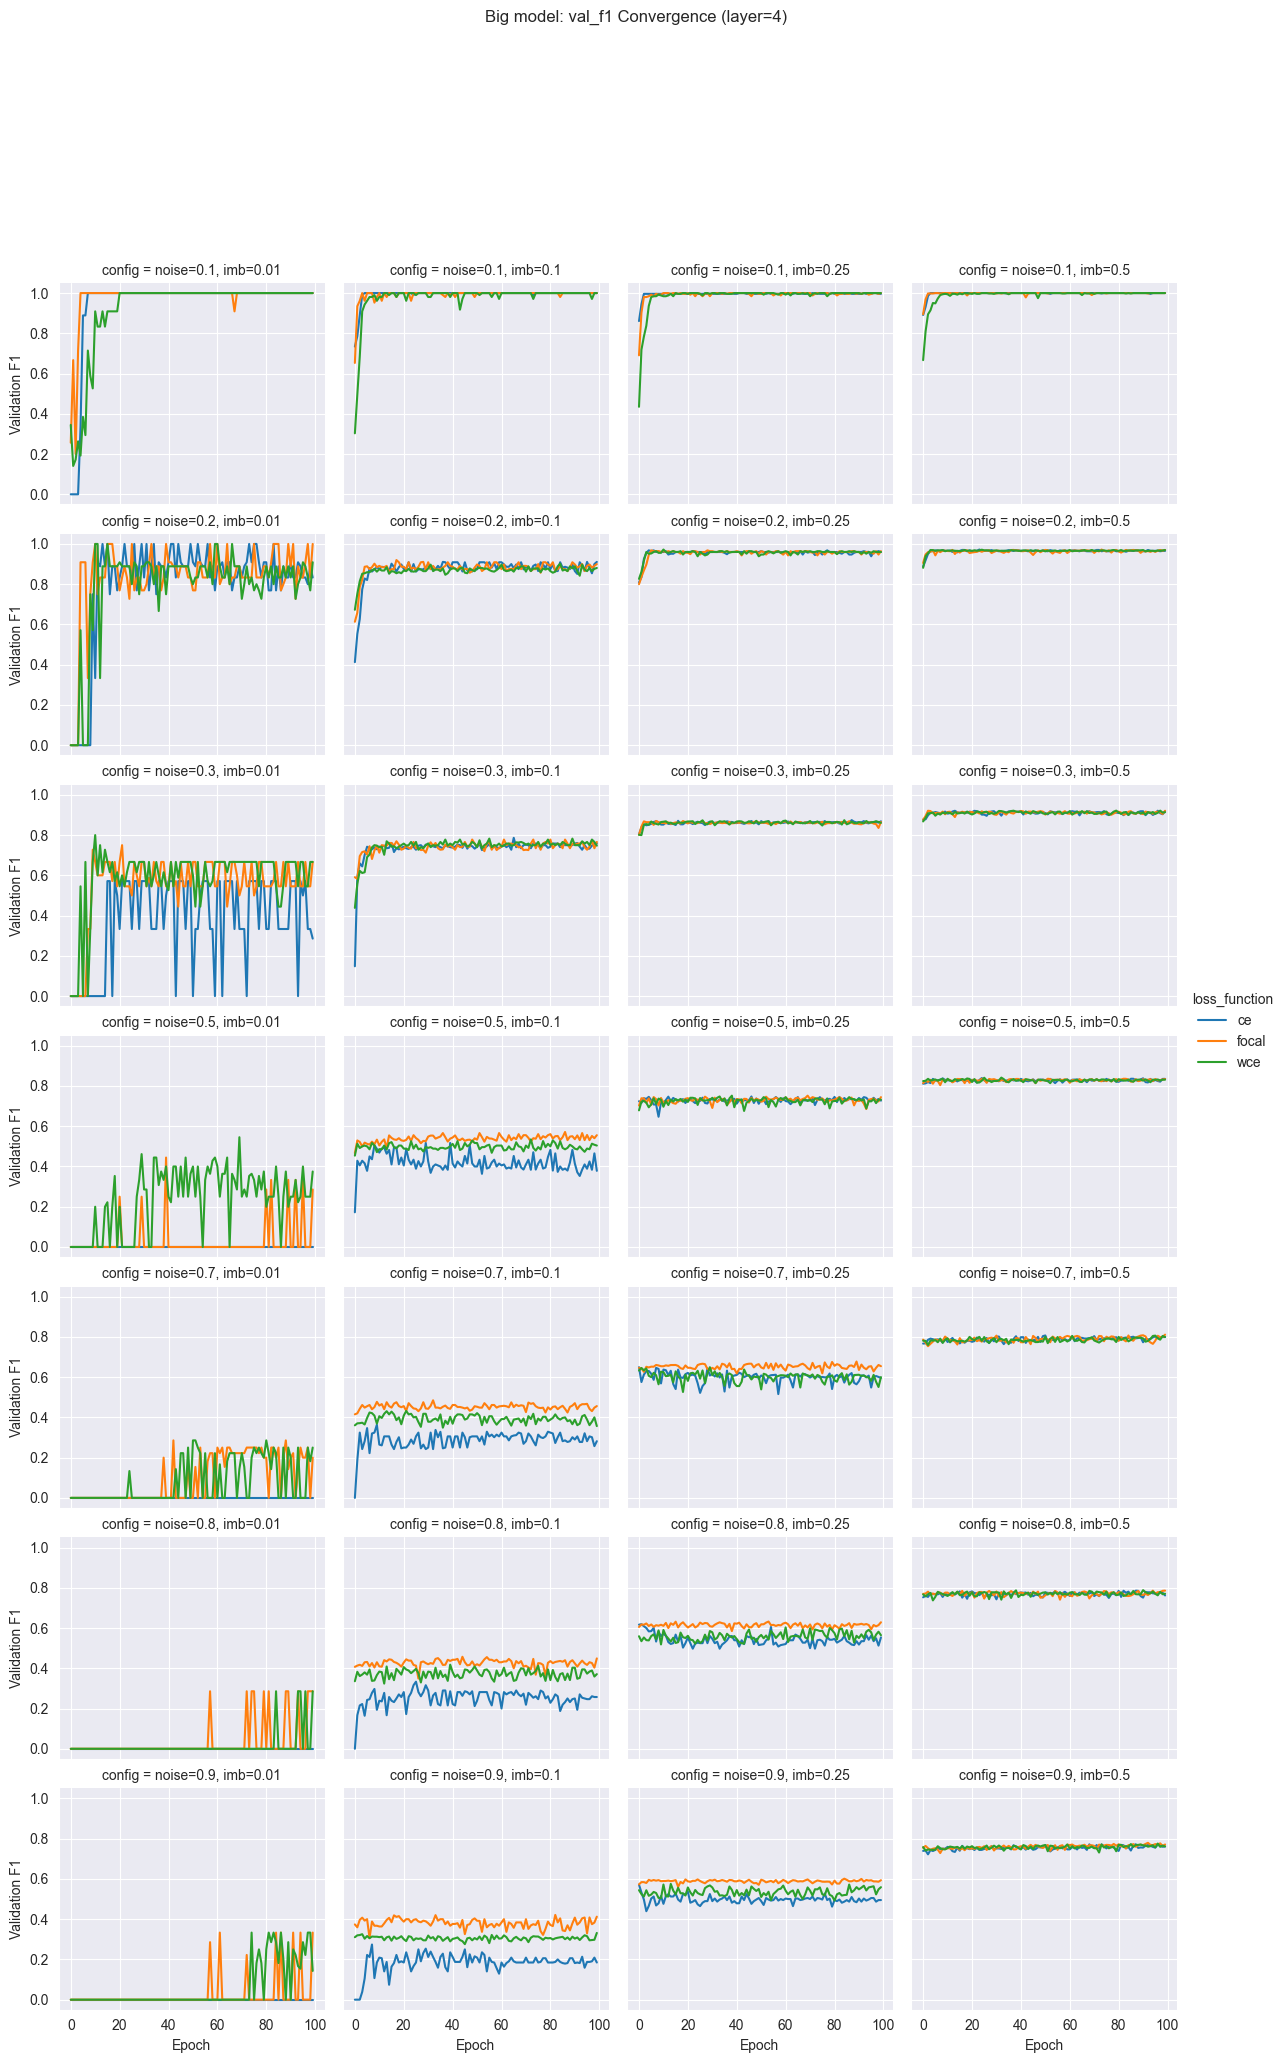

In [9]:
def plot_convergence_grid(hist_df: pd.DataFrame, num_layer: int, title_prefix: str):
    if hist_df.empty:
        print(f"No history found for {num_layer} layers")
        return

    df = hist_df.copy()
    df['config'] = df.apply(lambda r: f"noise={r['noise']}, imb={r['imbalance_ratio']}", axis=1)

    g = sns.relplot(
        data=df,
        x="step",
        y="val_f1",
        hue="loss_function",
        kind="line",
        col="config",
        col_wrap=4,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
    )
    g.set_axis_labels("Epoch", "Validation F1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{title_prefix}: val_f1 Convergence (layer={num_layer})")
    plt.savefig(f"/Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Visulaisation/plots/{title_prefix}_Convergence.png")
    plt.show()

plot_convergence_grid(hist_small, 2, "Small model")
plot_convergence_grid(hist_big, 4, "Big model")


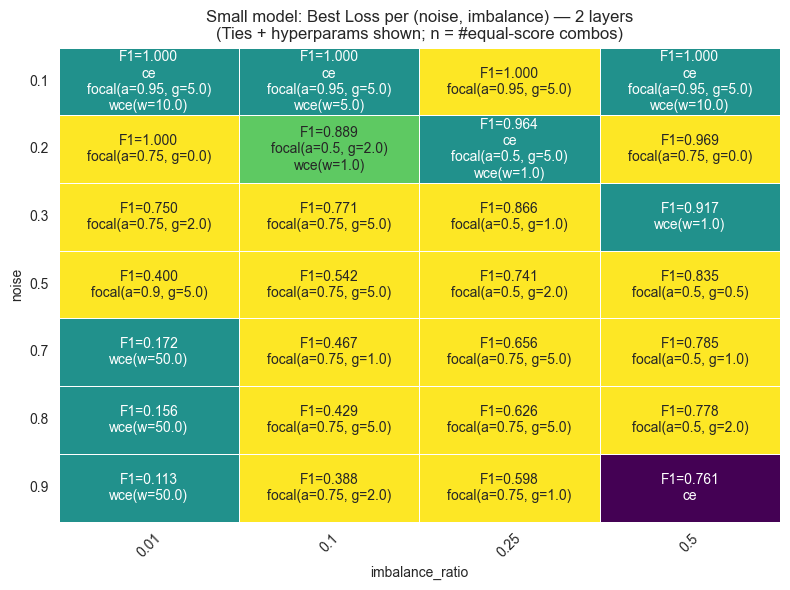

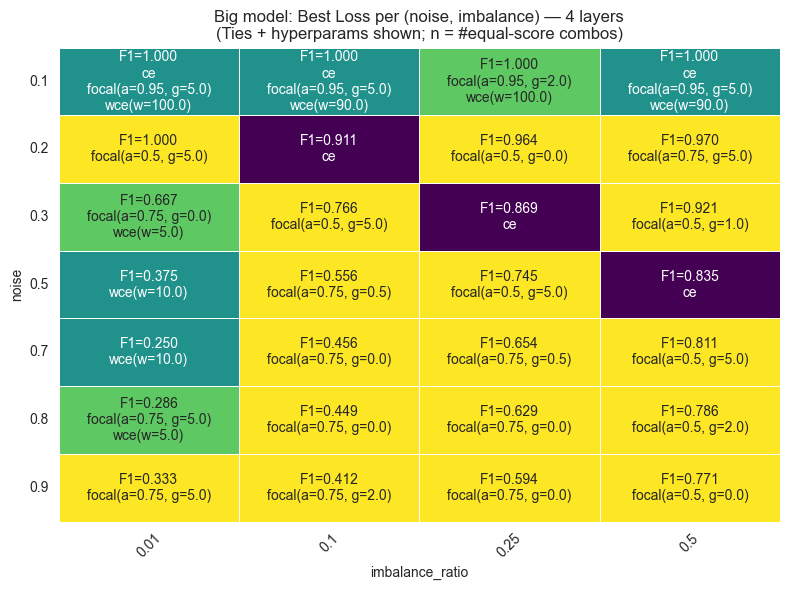

In [10]:
losses = ["ce", "wce", "focal"]  # desired order for coloring

def plot_best_loss_heatmap(best_df: pd.DataFrame, num_layer: int, title_prefix: str):
    df = best_df.copy()

    df['noise'] = df['noise'].astype(float)
    df['imbalance_ratio'] = df['imbalance_ratio'].astype(float)
    grouped = df.groupby(['noise', 'imbalance_ratio'])
    rows = []

    for (noise, imb), g in grouped:
        max_val = g['metrics.val_f1'].max()
        best_rows = g[g['metrics.val_f1'] == max_val]

        # Group by loss + hyperparams to detect multiple identical combinations
        combo_counts = {}  # key -> count
        for _, r in best_rows.iterrows():
            loss_fn = r['loss_function']
            ce_w   = r.get('params.ce_weight', None)
            alpha  = r.get('params.alpha', None)
            gamma  = r.get('params.gamma', None)
            key = (loss_fn, ce_w, alpha, gamma)
            combo_counts[key] = combo_counts.get(key, 0) + 1

        labels = []
        loss_indices = set()

        for (loss_fn, ce_w, alpha, gamma), count in combo_counts.items():
            # track which losses appear for coloring
            if loss_fn in losses:
                loss_indices.add(losses.index(loss_fn))

            # build label depending on loss type
            if loss_fn == "wce":
                label_base = (
                    f"wce(w={ce_w})" if ce_w is not None and ce_w == ce_w  # not NaN
                    else "wce"
                )
            elif loss_fn == "focal":
                if (alpha is not None and alpha == alpha) and (gamma is not None and gamma == gamma):
                    label_base = f"focal(a={alpha}, g={gamma})"
                else:
                    label_base = "focal"
            else:
                label_base = loss_fn  # e.g. "ce"

            # add (n=k) if multiple combinations got the same score
            if count > 1:
                label = f"{label_base} (n={count})"
            else:
                label = label_base

            labels.append(label)

        score_text = f"F1={max_val:.3f}"
        if labels:
            annot = score_text + "\n" + "\n".join(labels)
        else:
            annot = score_text

        if loss_indices:
            mean_code = float(np.mean(list(loss_indices)))
        else:
            mean_code = 0.0  # fallback

        rows.append({
            "noise": noise,
            "imbalance_ratio": imb,
            "annot": annot,
            "loss_code": mean_code,
        })

    df_best = pd.DataFrame(rows)

    table = df_best.pivot(index='noise', columns='imbalance_ratio', values='loss_code')
    annot_table = df_best.pivot(index='noise', columns='imbalance_ratio', values='annot')

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        table,
        annot=annot_table,
        fmt="",
        cmap='viridis',
        linewidths=0.5,
        cbar=False
    )

    ax.set_title(
        f"{title_prefix}: Best Loss per (noise, imbalance) — {num_layer} layers\n"
        "(Ties + hyperparams shown; n = #equal-score combos)"
    )
    ax.set_xlabel("imbalance_ratio")
    ax.set_ylabel("noise")

    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"/Users/jannis/PycharmProjects/class-imbalance-loss-comparison/Visulaisation/plots/{title_prefix}_Convergence.png")
    plt.show()


# calls stay the same
plot_best_loss_heatmap(best_small, 2, "Small model")
plot_best_loss_heatmap(best_big,   4, "Big model")


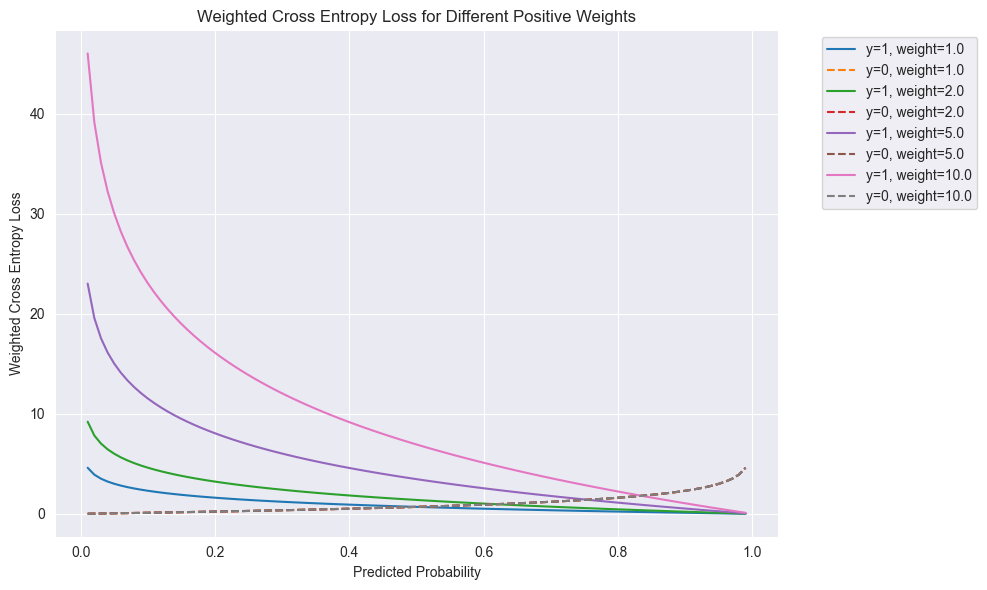

In [11]:
def weighted_cross_entropy(y_true, y_pred, weight):
    """
    Calculate weighted cross entropy loss
    weight: weight for positive class
    """
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    loss = -(weight * y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)

# Generate sample predictions
y_pred = np.linspace(0.01, 0.99, 100)

# Different weights for positive class
weights = [1.0, 2.0, 5.0, 10.0]

plt.figure(figsize=(10, 6))

for weight in weights:
    losses_positive = [weighted_cross_entropy(1, pred, weight) for pred in y_pred]
    losses_negative = [weighted_cross_entropy(0, pred, weight) for pred in y_pred]

    plt.plot(y_pred, losses_positive, label=f'y=1, weight={weight}', linestyle='-')
    plt.plot(y_pred, losses_negative, label=f'y=0, weight={weight}', linestyle='--')

plt.xlabel('Predicted Probability')
plt.ylabel('Weighted Cross Entropy Loss')
plt.title('Weighted Cross Entropy Loss for Different Positive Weights')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig("PlotYannick.png")
plt.show()